
# Descrição do Desafio
O projeto consiste em aplicar o método de transfer learning em uma rede de Deep Learning na linguagem Python. Isso para uma base de dados com imagens de cachorros e gatos. Assim, este código utiliza um algoritmo de inteligência artificial para realizar uma classificação binaria, entre duas classes distintas.
O dataset utilizado possui imagens no formato jpg com duas classes: gatos e cachorros.

[Link para baixar o dataset](https://www.kaggle.com/datasets/tongpython/cat-and-dog)



In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#importe os pacotes necessários
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2   # Redes neurais keras: https://keras.io/api/applications/
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# inicializa a taxa de aprendizado inicial, o número de épocas para treinar e o tamanho do lote
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [19]:
train_dir ='/content/drive/MyDrive/dataset_kaggle'
CATEGORIES = ['cats','dogs']

print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [20]:
for category in CATEGORIES:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224,224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [21]:
# one-hot encoding das labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [22]:
# divisão dos dados de treino e teste 
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [ ]:
# construir o gerador de imagem de treinamento para aumento de dados
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## Modelo de Deep Learning para o treinamento: MobileNetV2
Transfer learning por uma rede neural existente

In [23]:
# carregando o modelo MobileNetV2 do keras. Este modelo utiliza os pesos da ImageNet.
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# camadas base do modelo para o aprendizado
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

9406464/9406464 [==============================] - 0s 0us/step


In [24]:
# loop para atualização após o primeiro processo de treinamento
for layer in baseModel.layers:
	layer.trainable = False

# compilação do modelo
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
# Incializando o processo de treinamento da rede MobileNetV2
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
3/3 [==============================] - 7s 1s/step - loss: 0.8347 - accuracy: 0.5195
Epoch 2/10
3/3 [==============================] - 4s 1000ms/step - loss: 0.7166 - accuracy: 0.5584
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.6425 - accuracy: 0.6494
Epoch 4/10
3/3 [==============================] - 4s 1s/step - loss: 0.5561 - accuracy: 0.7604
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 0.5709 - accuracy: 0.7292
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.5900 - accuracy: 0.7143
Epoch 7/10
3/3 [==============================] - 4s 1s/step - loss: 0.4477 - accuracy: 0.8958
Epoch 8/10
3/3 [==============================] - 3s 882ms/step - loss: 0.4076 - accuracy: 0.8831
Epoch 9/10
3/3 [==============================] - 3s 893ms/step - loss: 0.3547 - accuracy: 0.9351
Epoch 10/10
3/3 [==============================] - 3s 912ms/step - loss: 0.3137 - accuracy: 0.9351


In [26]:
# Previsões sobre o conjunto de testes
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# Para cada imagem no conjunto de teste, precisamos encontrar o índice do rótulo com a maior probabilidade prevista correspondente
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# salvar o modelo treinado
print("[INFO] saving cat and dog detector model...")
model.save("cat-and-dog_detector.model", save_format="h5")

[INFO] evaluating network...
1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

        cats       1.00      0.80      0.89        10
        dogs       0.90      1.00      0.95        18

    accuracy                           0.93        28
   macro avg       0.95      0.90      0.92        28
weighted avg       0.94      0.93      0.93        28

[INFO] saving cat and dog detector model...


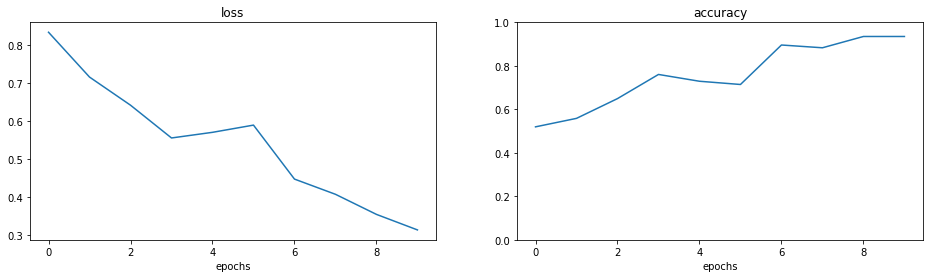

In [27]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(H.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(H.history["accuracy"])
ax2.set_title("accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

# Teste do modelo

In [28]:
# importe os pacotes necessários
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse
import imutils
import time
import cv2
import os

[INFO] loading trained model for cat and dog classification...
1/1 [==============================] - 1s 932ms/step


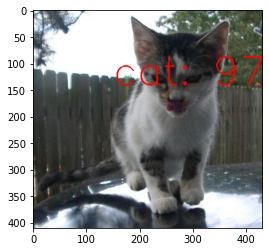

In [29]:
# Teste 
print("[INFO] loading trained model for cat and dog classification...")
model = tf.keras.models.load_model('cat-and-dog_detector.model')
image = cv2.imread("/content/drive/MyDrive/dataset_kaggle/cats/11.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(dog,cat) = model.predict(img)[0]
label = "dog" if dog < cat else "cat"
color = (0, 255, 0) if label == "dog" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(dog, cat) * 100)
cv2.putText(image, label, (150, 150 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 2.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

[INFO] loading trained model for cat and dog classification...


1/1 [==============================] - 1s 1s/step


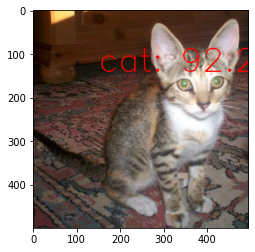

In [33]:
# Teste 2 
print("[INFO] loading trained model for cat and dog classification...")
model = tf.keras.models.load_model('cat-and-dog_detector.model')
image = cv2.imread("/content/drive/MyDrive/dataset_kaggle/cats/7.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(dog,cat) = model.predict(img)[0]
label = "dog" if dog < cat else "cat"
color = (0, 255, 0) if label == "dog" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(dog, cat) * 100)
cv2.putText(image, label, (150, 150 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 2.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

[INFO] loading trained model for cat and dog classification...
1/1 [==============================] - 1s 836ms/step


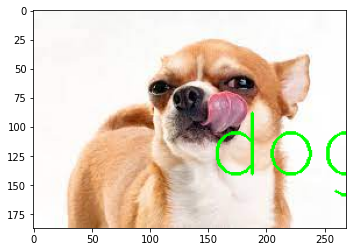

In [37]:
# Teste 4
print("[INFO] loading trained model for cat and dog classification...")
model = tf.keras.models.load_model('cat-and-dog_detector.model')
image = cv2.imread("/content/drive/MyDrive/dataset_kaggle/teste4.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(dog,cat) = model.predict(img)[0]
label = "dog" if dog < cat else "cat"
color = (0, 255, 0) if label == "dog" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(dog, cat) * 100)
cv2.putText(image, label, (150, 150 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 2.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()